In [79]:
import os, re
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [80]:
data_root_path = '.' + os.sep + 'data'
data_files_name = os.listdir(data_root_path)
data_files_name

['safe-boom-40-swing-180-load-40-.csv',
 'safe-boom-50-swing-180-load-50-.csv',
 'safe-boom-60-swing-180-load-60-.csv',
 'safe-boom-70-swing-180-load-100-.csv',
 'safe-boom-80-swing-180-load-120-.csv',
 'unsafe-swing-0-load-70-.csv',
 'unsafe-swing-0-load-90-.csv',
 'unsafe-swing-135-load-50-.csv',
 'unsafe-swing-135-load-70-.csv',
 'unsafe-swing-180-load-70-.csv',
 'unsafe-swing-180-load-90-.csv',
 'unsafe-swing-45-load-50-.csv',
 'unsafe-swing-45-load-70-.csv',
 'unsafe-swing-90-load-70-.csv',
 'unsafe-swing-90-load-90-.csv']

In [81]:
def get_load_value(data_file_name):
    re_iter = re.compile('['+ 'load' + ']+').finditer(data_file_name)
    load_idx = 0
    
    for i in re_iter:
        if i.group() == 'load':
            load_idx = i.end()
            load_idx += 1
            break

    load_str = data_file_name[load_idx:]
    load = int(load_str[0:load_str.find('-')])
    
    return load

In [82]:
get_load_value(data_files_name[0])

40

In [83]:
feature_names = ['Boom_Angle(deg)', 'Swing_Angle(deg)', 'Load(Ton)']
target_names = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Left_3(N)', 'Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)',
               'Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)', 'Actual_Load_Right_3(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

In [84]:
data_header = ['Time(sec)'] + target_names + feature_names

In [85]:
raw_dataset = pd.DataFrame()

for file_name in data_files_name: 
    raw = pd.read_csv('data' + os.sep + file_name, encoding='cp949', header=None)
    print(file_name)
    raw.drop(0, inplace=True)
    raw.columns = data_header
    raw.reset_index(inplace=True, drop=True)
    raw = raw.astype(np.float64)
 
    load = get_load_value(file_name)
    raw['Load(Ton)'] = np.full(shape=(raw.shape[0]), fill_value=load, dtype=np.float64)
    
    # raw = pd.concat([raw, load_df], axis=1)
    raw_dataset = pd.concat([raw_dataset, raw], axis=0) 

raw_dataset.reset_index(inplace=True, drop=True)

safe-boom-40-swing-180-load-40-.csv
safe-boom-50-swing-180-load-50-.csv
safe-boom-60-swing-180-load-60-.csv
safe-boom-70-swing-180-load-100-.csv
safe-boom-80-swing-180-load-120-.csv
unsafe-swing-0-load-70-.csv
unsafe-swing-0-load-90-.csv
unsafe-swing-135-load-50-.csv
unsafe-swing-135-load-70-.csv
unsafe-swing-180-load-70-.csv
unsafe-swing-180-load-90-.csv
unsafe-swing-45-load-50-.csv
unsafe-swing-45-load-70-.csv
unsafe-swing-90-load-70-.csv
unsafe-swing-90-load-90-.csv


In [86]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67504 entries, 0 to 67503
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time(sec)               67504 non-null  float64
 1   Actual_Load_Left_1(N)   67504 non-null  float64
 2   Actual_Load_Left_2(N)   67504 non-null  float64
 3   Actual_Load_Left_3(N)   67504 non-null  float64
 4   Actual_Load_Left_4(N)   67504 non-null  float64
 5   Actual_Load_Left_5(N)   67504 non-null  float64
 6   Actual_Load_Right_1(N)  67504 non-null  float64
 7   Actual_Load_Right_2(N)  67504 non-null  float64
 8   Actual_Load_Right_3(N)  67504 non-null  float64
 9   Actual_Load_Right_4(N)  67504 non-null  float64
 10  Actual_Load_Right_5(N)  67504 non-null  float64
 11  Boom_Angle(deg)         67504 non-null  float64
 12  Swing_Angle(deg)        67504 non-null  float64
 13  Load(Ton)               67504 non-null  float64
dtypes: float64(14)
memory usage: 7.2 MB


In [87]:
raw_dataset.describe()

,Time(sec),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),Boom_Angle(deg),Swing_Angle(deg),Load(Ton)
count,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,67504.000000,6.750400e+04,6.750400e+04,67504.000000
mean,28.112935,282909.899834,273685.066012,257988.959168,245345.324625,233104.149780,212995.138457,196390.752703,178925.159554,169667.846967,165599.965698,-7.348069e+00,7.795745e+01,70.816544
std,18.086489,121726.434288,86697.540295,63765.755395,90934.681480,126266.974592,122584.659862,86504.350732,50878.574396,81859.043718,116626.167821,1.169803e+01,6.218456e+01,22.980703
min,0.010229,-115.016350,-57.506040,6349.738300,-47.974237,-95.950965,-182.729430,-181.494030,-180.258630,-179.023230,-177.787830,-3.000000e+01,-2.000000e-24,40.000000
25%,13.410253,204351.607500,214669.010000,211333.877500,188187.182500,135606.352500,112334.765000,141563.040000,149515.422500,116891.422500,69675.277500,-1.829386e+01,1.820697e+01,50.000000
50%,25.580253,304044.200000,276781.265000,251715.360000,245879.435000,215510.010000,208338.625000,197831.725000,188574.120000,161130.455000,145128.935000,-1.570000e-27,7.043116e+01,70.000000
75%,40.140253,364859.327500,322110.710000,284664.490000,299716.502500,330442.630000,303026.335000,243648.072500,208186.140000,202658.527500,237654.177500,1.880000e-29,1.350000e+02,90.000000
max,70.000000,500095.960000,500047.980000,500136.680000,500118.530000,500115.020000,500096.040000,500048.020000,500137.350000,500119.180000,500115.130000,1.000000e+01,1.800000e+02,120.000000


In [88]:
raw_dataset_fix = raw_dataset.copy()

raw_dataset_fix = raw_dataset_fix[raw_dataset_fix['Time(sec)'] > 2.0]

for target_name in target_names:
    raw_dataset_fix = raw_dataset_fix[raw_dataset_fix[target_name] > 1000]
    
raw_dataset_fix['Boom_Angle(deg)'] = raw_dataset_fix['Boom_Angle(deg)']+70

raw_dataset_fix.reset_index(inplace=True, drop=True)

In [89]:
raw_dataset_fix.describe()

,Time(sec),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),Boom_Angle(deg),Swing_Angle(deg),Load(Ton)
count,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,6.087100e+04,60871.000000
mean,28.875554,280422.592136,270237.084090,258115.064891,245821.533684,235121.489564,208907.886712,195590.405726,182915.003344,172599.398158,166361.308790,63.522117,8.060910e+01,70.674213
std,18.092565,110251.077707,71299.199016,49544.008131,74166.152030,113700.394654,109497.653116,67401.064979,40343.466021,65883.347587,106141.988916,11.368717,6.067734e+01,23.782712
min,2.000253,1110.565100,65531.646000,182283.150000,68403.978000,1021.962700,1038.630700,2564.975100,2840.951400,1822.599300,1008.097000,40.000000,-4.460000e-28,40.000000
25%,14.040253,205526.625000,214893.785000,214806.800000,191040.510000,146915.495000,115677.520000,144686.690000,154934.520000,122235.345000,76861.331500,59.482090,2.447425e+01,50.000000
50%,25.900253,298403.960000,276243.670000,254013.650000,249783.680000,227816.670000,206676.580000,197480.510000,188396.680000,162150.420000,148232.800000,70.000000,7.570023e+01,70.000000
75%,40.390253,358802.150000,313970.765000,283762.100000,297342.985000,327831.640000,294893.755000,238512.025000,207051.825000,204654.845000,237303.410000,70.000000,1.350000e+02,90.000000
max,70.000000,493258.060000,470991.390000,474538.750000,477879.600000,491796.740000,492245.480000,392905.520000,281262.870000,391790.070000,491543.670000,80.000000,1.800000e+02,120.000000


In [90]:
raw_dataset_fix

,Time(sec),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),Boom_Angle(deg),Swing_Angle(deg),Load(Ton)
0,2.000253,170062.47,180680.23,191420.21,202263.13,213189.69,168664.7200,179283.9400,190028.3600,200878.5800,211815.210,66.879271,1.560000e-30,40.0
1,2.010253,169988.02,180641.70,191418.53,202299.00,213263.63,168592.2200,179247.3300,190028.5700,200916.3500,211891.060,66.850415,-4.820000e-30,40.0
2,2.020253,170243.17,180771.25,191419.30,202168.53,213000.13,168843.8000,179373.4500,190025.9800,200782.5100,211624.140,66.821450,3.790000e-30,40.0
3,2.030253,170218.60,180761.86,191425.46,202190.51,213038.14,168805.8100,179350.5400,190018.5600,200790.8900,211648.560,66.792379,3.020000e-30,40.0
4,2.040253,170446.06,180881.53,191434.63,202087.07,212820.55,169013.4300,179450.3900,190007.9100,200667.6000,211411.080,66.763200,-2.210000e-30,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60866,30.080253,466861.72,469939.30,472885.15,475696.30,478369.78,2391.8443,4189.5085,6463.6691,9200.0780,12384.487,54.638893,9.000000e+01,90.0
60867,30.090253,467010.30,470228.10,473300.71,476224.68,478996.60,2036.8146,3778.6999,6029.9405,8774.9342,11998.079,54.593906,9.000000e+01,90.0
60868,30.100253,467125.65,470500.43,473714.28,476763.24,479643.31,1692.7003,3370.7405,5595.7670,8350.5832,11617.992,54.548922,9.000000e+01,90.0
60869,30.110253,467204.29,470754.94,474126.27,477313.61,480312.29,1362.3229,2966.2656,5160.4804,7925.8818,11243.384,54.503942,9.000000e+01,90.0


In [91]:
feature_data = raw_dataset_fix[feature_names]
target_data = raw_dataset_fix[target_names]

In [92]:
feature_data

,Boom_Angle(deg),Swing_Angle(deg),Load(Ton)
0,66.879271,1.560000e-30,40.0
1,66.850415,-4.820000e-30,40.0
2,66.821450,3.790000e-30,40.0
3,66.792379,3.020000e-30,40.0
4,66.763200,-2.210000e-30,40.0
...,...,...,...
60866,54.638893,9.000000e+01,90.0
60867,54.593906,9.000000e+01,90.0
60868,54.548922,9.000000e+01,90.0
60869,54.503942,9.000000e+01,90.0


In [93]:
target_data

,Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N)
0,170062.47,180680.23,191420.21,202263.13,213189.69,168664.7200,179283.9400,190028.3600,200878.5800,211815.210
1,169988.02,180641.70,191418.53,202299.00,213263.63,168592.2200,179247.3300,190028.5700,200916.3500,211891.060
2,170243.17,180771.25,191419.30,202168.53,213000.13,168843.8000,179373.4500,190025.9800,200782.5100,211624.140
3,170218.60,180761.86,191425.46,202190.51,213038.14,168805.8100,179350.5400,190018.5600,200790.8900,211648.560
4,170446.06,180881.53,191434.63,202087.07,212820.55,169013.4300,179450.3900,190007.9100,200667.6000,211411.080
...,...,...,...,...,...,...,...,...,...,...
60866,466861.72,469939.30,472885.15,475696.30,478369.78,2391.8443,4189.5085,6463.6691,9200.0780,12384.487
60867,467010.30,470228.10,473300.71,476224.68,478996.60,2036.8146,3778.6999,6029.9405,8774.9342,11998.079
60868,467125.65,470500.43,473714.28,476763.24,479643.31,1692.7003,3370.7405,5595.7670,8350.5832,11617.992
60869,467204.29,470754.94,474126.27,477313.61,480312.29,1362.3229,2966.2656,5160.4804,7925.8818,11243.384


In [94]:
dataset = pd.concat([feature_data, target_data], axis=1)
dataset.describe()

,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N)
count,60871.000000,6.087100e+04,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000
mean,63.522117,8.060910e+01,70.674213,280422.592136,270237.084090,258115.064891,245821.533684,235121.489564,208907.886712,195590.405726,182915.003344,172599.398158,166361.308790
std,11.368717,6.067734e+01,23.782712,110251.077707,71299.199016,49544.008131,74166.152030,113700.394654,109497.653116,67401.064979,40343.466021,65883.347587,106141.988916
min,40.000000,-4.460000e-28,40.000000,1110.565100,65531.646000,182283.150000,68403.978000,1021.962700,1038.630700,2564.975100,2840.951400,1822.599300,1008.097000
25%,59.482090,2.447425e+01,50.000000,205526.625000,214893.785000,214806.800000,191040.510000,146915.495000,115677.520000,144686.690000,154934.520000,122235.345000,76861.331500
50%,70.000000,7.570023e+01,70.000000,298403.960000,276243.670000,254013.650000,249783.680000,227816.670000,206676.580000,197480.510000,188396.680000,162150.420000,148232.800000
75%,70.000000,1.350000e+02,90.000000,358802.150000,313970.765000,283762.100000,297342.985000,327831.640000,294893.755000,238512.025000,207051.825000,204654.845000,237303.410000
max,80.000000,1.800000e+02,120.000000,493258.060000,470991.390000,474538.750000,477879.600000,491796.740000,492245.480000,392905.520000,281262.870000,391790.070000,491543.670000


<Axes: xlabel='Boom_Angle(deg)', ylabel='Count'>

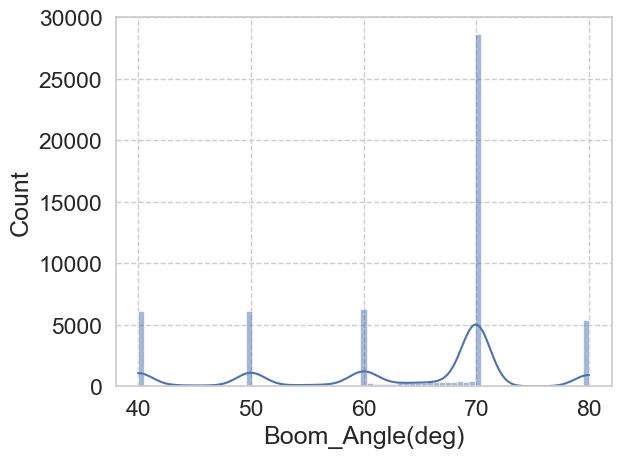

In [95]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(dataset['Boom_Angle(deg)'], kde='True')

<Axes: xlabel='Swing_Angle(deg)', ylabel='Count'>

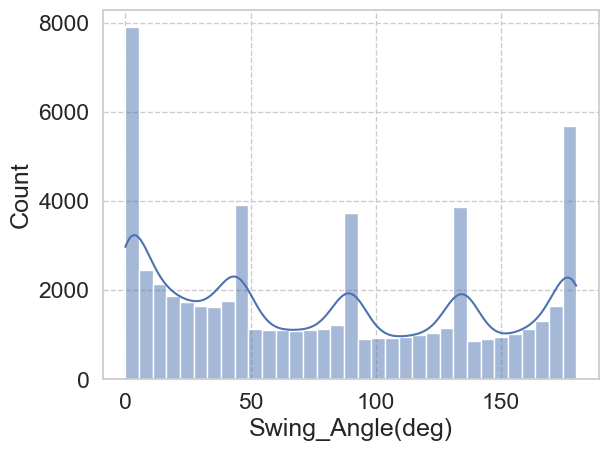

In [96]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(dataset['Swing_Angle(deg)'], kde='True')

<Axes: xlabel='Load(Ton)', ylabel='Count'>

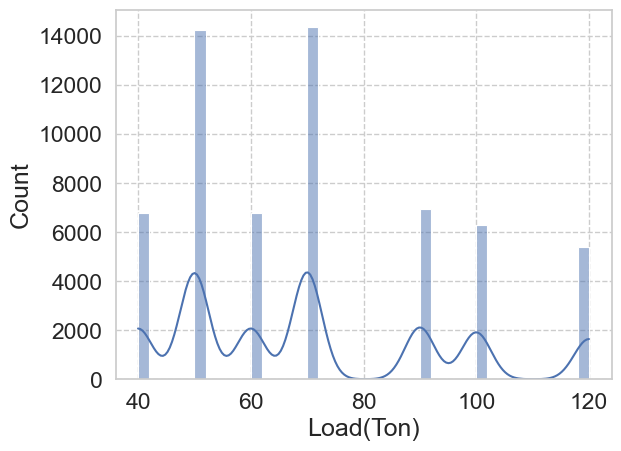

In [97]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(dataset['Load(Ton)'], kde='True')

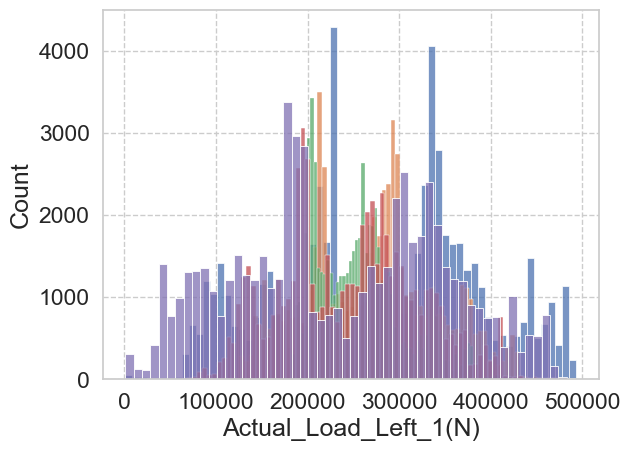

In [98]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for name in target_names[0:5]:
    sns.histplot(dataset[name])

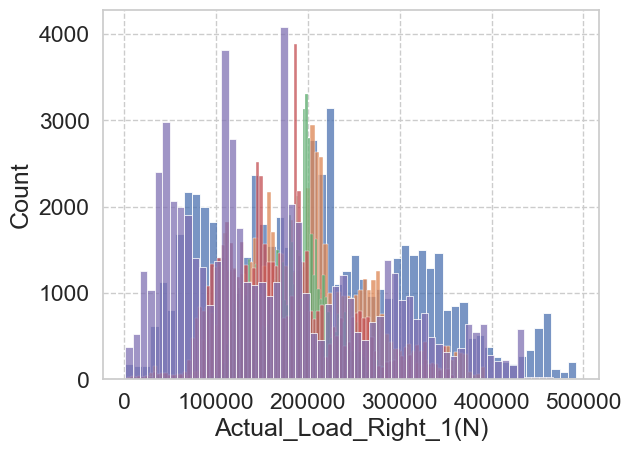

In [99]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for name in target_names[5:10]:
    sns.histplot(dataset[name])

<Axes: >

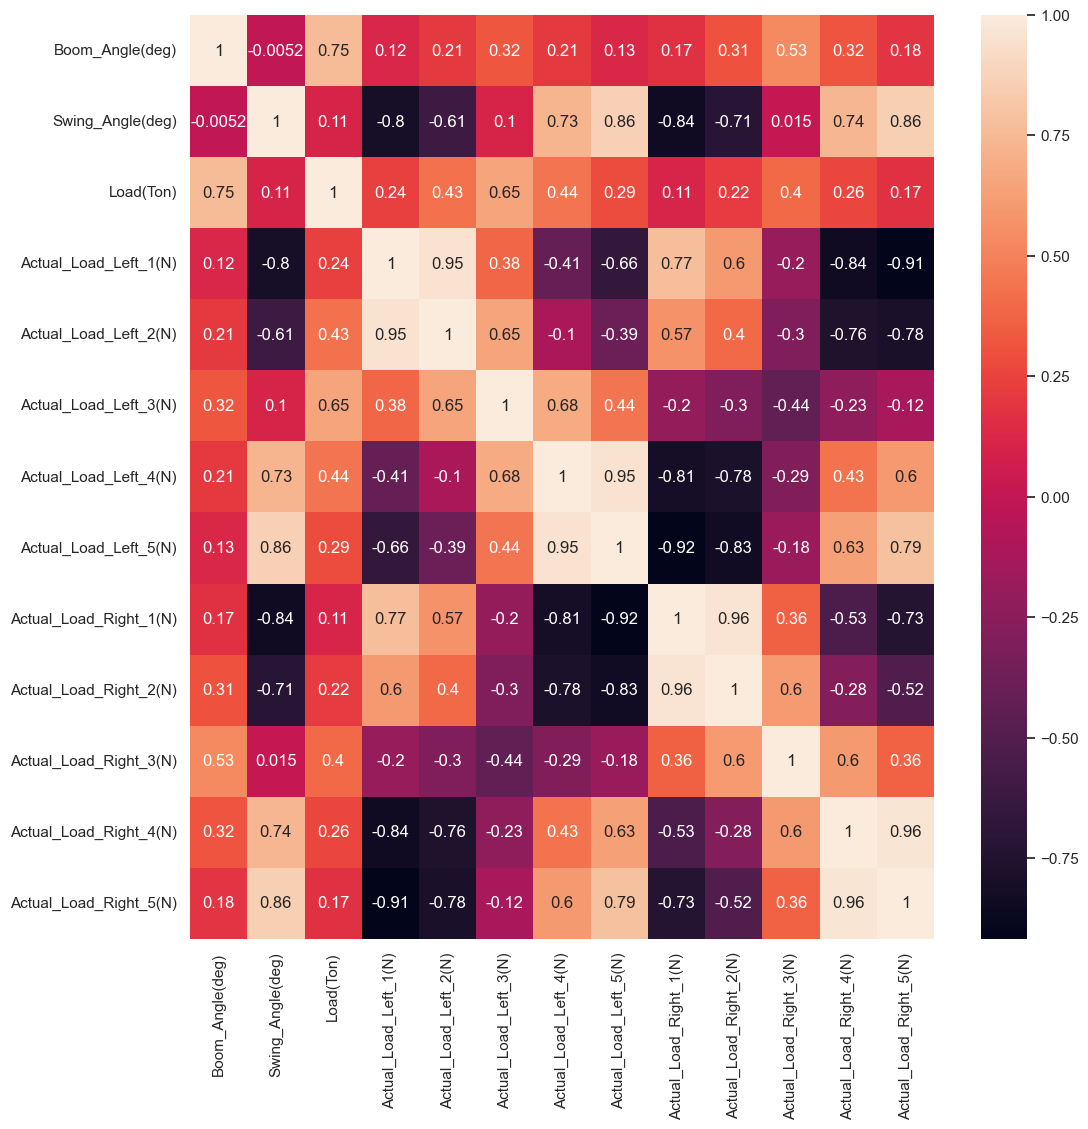

In [100]:
sns.set(font_scale=1)
plt.figure(figsize=(12, 12))
sns.heatmap(dataset.corr(), annot=True)

In [101]:
model = XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=10, eval_metric='rmsle', nthread=os.cpu_count())

In [102]:
# model training
model.fit(dataset[feature_names], dataset[target_names], verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, nthread=48, num_parallel_tree=None,
             predictor=None, ...)

In [103]:
# prediction
pred_out = model.predict(dataset[feature_names])
pred_target_names = ['Pred_Load_Left_1(N)', 'Pred_Load_Left_2(N)', 'Pred_Load_Left_3(N)', 'Pred_Load_Left_4(N)', 'Pred_Load_Left_5(N)',
                     'Pred_Load_Right_1(N)', 'Pred_Load_Right_2(N)', 'Pred_Load_Right_3(N)', 'Pred_Load_Right_4(N)', 'Pred_Load_Right_5(N)']

target_pred = pd.DataFrame(pred_out, columns=pred_target_names)

In [104]:
absolute_error_names = ['Absolute_Error_Left_1(%)', 'Absolute_Error_Left_2(%)', 'Absolute_Error_Left_3(%)', 'Absolute_Error_Left_4(%)', 'Absolute_Error_Left_5(%)',
                        'Absolute_Error_Right_1(%)', 'Absolute_Error_Right_2(%)', 'Absolute_Error_Right_3(%)', 'Absolute_Error_Right_4(%)', 'Absolute_Error_Right_5(%)']

relative_error_names = ['Relative_Error_Left_1(%)', 'Relative_Error_Left_2(%)', 'Relative_Error_Left_3(%)', 'Relative_Error_Left_4(%)', 'Relative_Error_Left_5(%)',
                        'Relative_Error_Right_1(%)', 'Relative_Error_Right_2(%)', 'Relative_Error_Right_3(%)', 'Relative_Error_Right_4(%)', 'Relative_Error_Right_5(%)']

actual_load = dataset[target_names].to_numpy()
pred_load = target_pred.to_numpy()

absolute_error = pd.DataFrame(abs(actual_load-pred_load), columns=absolute_error_names)
relative_error = pd.DataFrame((abs(actual_load-pred_load)/abs(actual_load))*100, columns=relative_error_names)
result = pd.concat([raw_dataset_fix['Time(sec)'], dataset, target_pred, absolute_error, relative_error], axis=1)

result.describe()

,Time(sec),Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),...,Relative_Error_Left_1(%),Relative_Error_Left_2(%),Relative_Error_Left_3(%),Relative_Error_Left_4(%),Relative_Error_Left_5(%),Relative_Error_Right_1(%),Relative_Error_Right_2(%),Relative_Error_Right_3(%),Relative_Error_Right_4(%),Relative_Error_Right_5(%)
count,60871.000000,60871.000000,6.087100e+04,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,60871.000000,...,60871.000000,60871.000000,6.087100e+04,6.087100e+04,60871.000000,60871.000000,6.087100e+04,60871.000000,60871.000000,60871.000000
mean,28.875554,63.522117,8.060910e+01,70.674213,280422.592136,270237.084090,258115.064891,245821.533684,235121.489564,208907.886712,...,0.343695,0.250789,2.145683e-01,2.795146e-01,0.465332,0.502505,3.530023e-01,0.288349,0.377862,0.663279
std,18.092565,11.368717,6.067734e+01,23.782712,110251.077707,71299.199016,49544.008131,74166.152030,113700.394654,109497.653116,...,0.820977,0.595979,4.856436e-01,5.301326e-01,0.849429,1.187470,7.870485e-01,0.598508,0.703928,1.305812
min,2.000253,40.000000,-4.460000e-28,40.000000,1110.565100,65531.646000,182283.150000,68403.978000,1021.962700,1038.630700,...,0.000001,0.000000,9.979093e-07,8.894678e-07,0.000003,0.000006,7.693795e-08,0.000006,0.000001,0.000009
25%,14.040253,59.482090,2.447425e+01,50.000000,205526.625000,214893.785000,214806.800000,191040.510000,146915.495000,115677.520000,...,0.036215,0.024903,1.716959e-02,2.326540e-02,0.035851,0.046165,3.295070e-02,0.024252,0.037243,0.056346
50%,25.900253,70.000000,7.570023e+01,70.000000,298403.960000,276243.670000,254013.650000,249783.680000,227816.670000,206676.580000,...,0.103342,0.066944,4.879831e-02,6.925467e-02,0.116993,0.136305,9.277641e-02,0.065159,0.105739,0.177437
75%,40.390253,70.000000,1.350000e+02,90.000000,358802.150000,313970.765000,283762.100000,297342.985000,327831.640000,294893.755000,...,0.287983,0.199621,1.661570e-01,2.519135e-01,0.477025,0.447168,2.968427e-01,0.219398,0.326422,0.624899
max,70.000000,80.000000,1.800000e+02,120.000000,493258.060000,470991.390000,474538.750000,477879.600000,491796.740000,492245.480000,...,27.092115,8.088938,5.989112e+00,4.545230e+00,14.480153,40.962799,1.744382e+01,5.456655,6.268656,54.430024


In [105]:
result

,Time(sec),Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),...,Relative_Error_Left_1(%),Relative_Error_Left_2(%),Relative_Error_Left_3(%),Relative_Error_Left_4(%),Relative_Error_Left_5(%),Relative_Error_Right_1(%),Relative_Error_Right_2(%),Relative_Error_Right_3(%),Relative_Error_Right_4(%),Relative_Error_Right_5(%)
0,2.000253,66.879271,1.560000e-30,40.0,170062.47,180680.23,191420.21,202263.13,213189.69,168664.7200,...,0.122776,0.087329,0.025317,0.096836,0.132871,0.060206,0.063254,0.052328,0.062702,0.101551
1,2.010253,66.850415,-4.820000e-30,40.0,169988.02,180641.70,191418.53,202299.00,213263.63,168592.2200,...,0.186830,0.106281,0.030986,0.070525,0.165445,0.050927,0.032086,0.042580,0.102409,0.114975
2,2.020253,66.821450,3.790000e-30,40.0,170243.17,180771.25,191419.30,202168.53,213000.13,168843.8000,...,0.065174,0.057039,0.032364,0.065044,0.046591,0.031299,0.026840,0.060129,0.041156,0.075384
3,2.030253,66.792379,3.020000e-30,40.0,170218.60,180761.86,191425.46,202190.51,213038.14,168805.8100,...,0.053108,0.092188,0.015750,0.010391,0.062687,0.063045,0.070658,0.055289,0.029197,0.044766
4,2.040253,66.763200,-2.210000e-30,40.0,170446.06,180881.53,191434.63,202087.07,212820.55,169013.4300,...,0.069085,0.033638,0.027291,0.044864,0.032269,0.038223,0.032504,0.043347,0.025574,0.036194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60866,30.080253,54.638893,9.000000e+01,90.0,466861.72,469939.30,472885.15,475696.30,478369.78,2391.8443,...,0.002135,0.016442,0.010129,0.004892,0.010877,1.904867,1.576513,0.606573,0.717461,0.177557
60867,30.090253,54.593906,9.000000e+01,90.0,467010.30,470228.10,473300.71,476224.68,478996.60,2036.8146,...,0.006495,0.013306,0.010308,0.012276,0.017708,3.813368,1.343734,0.601668,0.744123,0.301335
60868,30.100253,54.548922,9.000000e+01,90.0,467125.65,470500.43,473714.28,476763.24,479643.31,1692.7003,...,0.016375,0.018622,0.002619,0.014975,0.031696,5.651148,1.997051,0.958656,0.539139,0.359266
60869,30.110253,54.503942,9.000000e+01,90.0,467204.29,470754.94,474126.27,477313.61,480312.29,1362.3229,...,0.021740,0.032322,0.020054,0.020339,0.040191,10.740804,3.039164,1.132765,0.862545,0.467669


In [106]:
for target_name, pred_name in zip(target_names, pred_target_names):
    print(target_name, r2_score(result[target_name], result[pred_name]))

Actual_Load_Left_1(N) 0.999733266092378
Actual_Load_Left_2(N) 0.999604297661849
Actual_Load_Left_3(N) 0.9993153282630657
Actual_Load_Left_4(N) 0.999584032098251
Actual_Load_Left_5(N) 0.999705704043249
Actual_Load_Right_1(N) 0.9996827739217597
Actual_Load_Right_2(N) 0.9995007726931784
Actual_Load_Right_3(N) 0.9989767069994282
Actual_Load_Right_4(N) 0.9995522196585465
Actual_Load_Right_5(N) 0.9997303570270598


In [107]:
for target_name, pred_name in zip(target_names, pred_target_names):
    print(target_name, mean_absolute_error(result[target_name], result[pred_name]))

Actual_Load_Left_1(N) 834.5960023124945
Actual_Load_Left_2(N) 632.2152888875655
Actual_Load_Left_3(N) 542.3340313326543
Actual_Load_Left_4(N) 653.9212877283519
Actual_Load_Left_5(N) 876.8017260576381
Actual_Load_Right_1(N) 885.6726394659274
Actual_Load_Right_2(N) 656.2466621319444
Actual_Load_Right_3(N) 529.1533075877933
Actual_Load_Right_4(N) 613.2437798775183
Actual_Load_Right_5(N) 789.2593583288648


In [108]:
for target_name, relative_error_name in zip(target_names, relative_error_names):
    print(target_name, result[relative_error_name].mean())

Actual_Load_Left_1(N) 0.34369510954413185
Actual_Load_Left_2(N) 0.2507894031716233
Actual_Load_Left_3(N) 0.2145682908293958
Actual_Load_Left_4(N) 0.27951460048168625
Actual_Load_Left_5(N) 0.4653321091212715
Actual_Load_Right_1(N) 0.5025049030207737
Actual_Load_Right_2(N) 0.3530022815402952
Actual_Load_Right_3(N) 0.28834944195220835
Actual_Load_Right_4(N) 0.3778615981533191
Actual_Load_Right_5(N) 0.6632793848885283


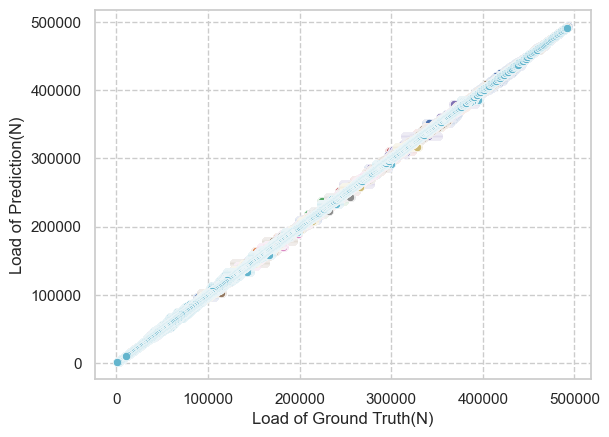

In [109]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Load of Ground Truth(N)')
plt.ylabel('Load of Prediction(N)')

for target_name, pred_target_name in zip(target_names, pred_target_names):
    sns.scatterplot(data=result, x=target_name, y=pred_target_name)

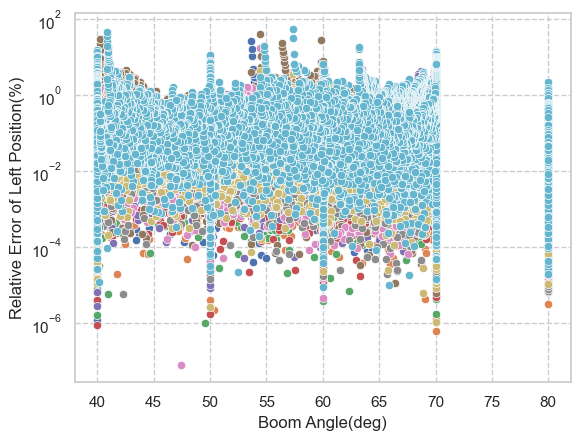

In [122]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Boom Angle(deg)')
plt.ylabel('Relative Error of Left Position(%)')
plt.yscale('log')

for relative_error_name in relative_error_names:
    sns.scatterplot(data=result, x='Boom_Angle(deg)', y=relative_error_name)

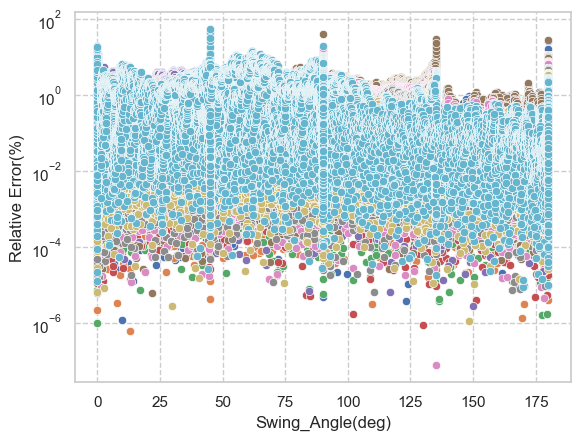

In [118]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(%)')

for relative_error_name in relative_error_names:
    sns.scatterplot(x=result['Swing_Angle(deg)'], y=result[relative_error_name])

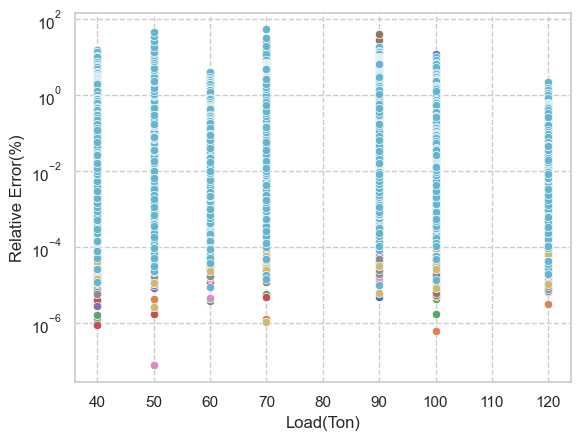

In [112]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(%)')

for relative_error_name in relative_error_names:
    sns.scatterplot(x=result['Load(Ton)'], y=result[relative_error_name])

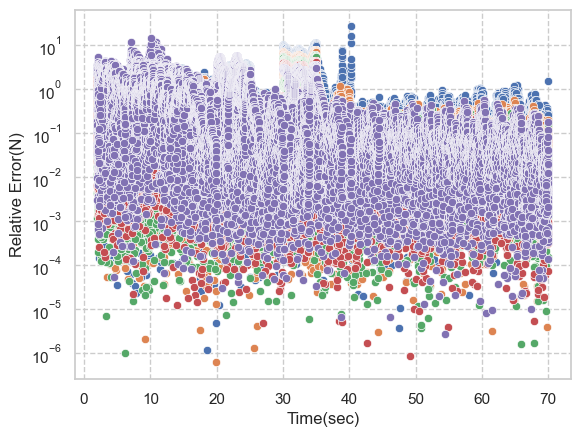

In [113]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(N)')

for relative_error_name in relative_error_names[0:5]:
    sns.scatterplot(x=result['Time(sec)'], y=result[relative_error_name])

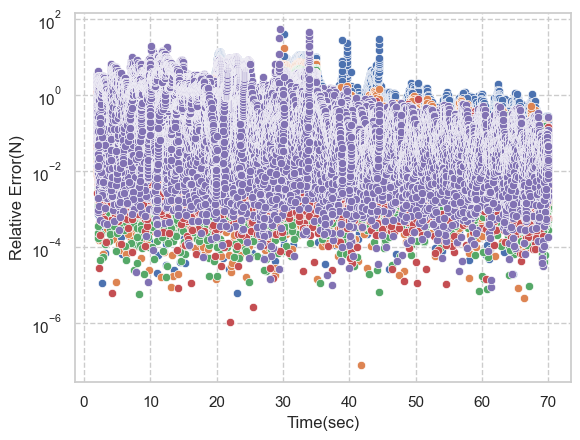

In [114]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(N)')

for relative_error_name in relative_error_names[5:10]:
    sns.scatterplot(x=result['Time(sec)'], y=result[relative_error_name])

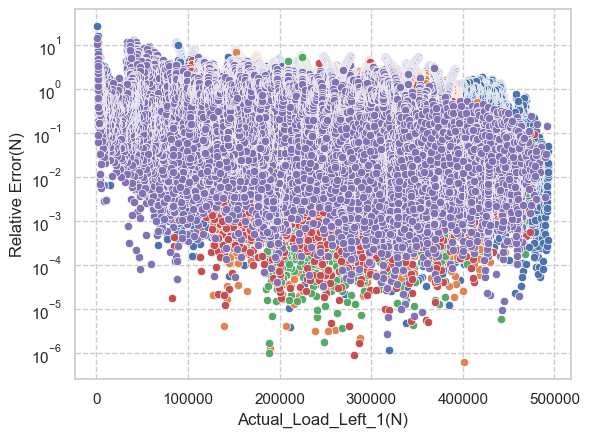

In [115]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(N)')

for target_name, relative_error_name in zip(target_names[0:5], relative_error_names[0:5]):
       sns.scatterplot(x=result[target_name], y=result[relative_error_name]) 

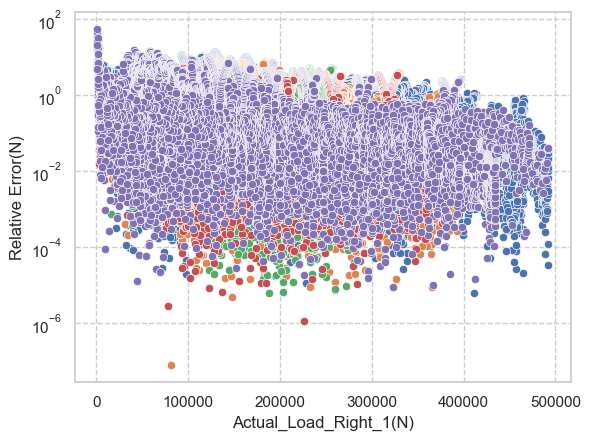

In [116]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.ylabel('Relative Error(N)')

for target_name, relative_error_name in zip(target_names[5:10], relative_error_names[5:10]):
       sns.scatterplot(x=result[target_name], y=result[relative_error_name]) 

In [117]:
filename = 'xgb_model.json'
model.save_model(filename)